[View in Colaboratory](https://colab.research.google.com/github/gr3ybr0w/cookbook/blob/master/Machine_Learning/Neural_Networks/pytorch/Loading_Data_Sets_with_Torchvision_pytorch.ipynb)

In [1]:
!pip install torch torchvision
!pip install kaggle
!git clone https://github.com/udacity/DL_PyTorch.git
!pip install --upgrade Pillow

fatal: destination path 'DL_PyTorch' already exists and is not an empty directory.
Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (5.2.0)


In [2]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


Download 100%.


In [0]:
from IPython.display import display, Image

# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:


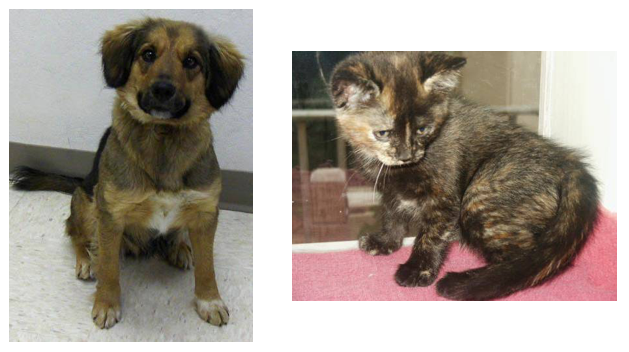

In [4]:
Image('DL_PyTorch/assets/dog_cat.png')


We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [5]:
!kaggle competitions download -c dogs-vs-cats -p /content/kaggle

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!ls kaggle

sampleSubmission.csv  test  test1  test1.zip  train  train.zip


In [0]:
! printf 'A' | unzip kaggle/test1.zip -d kaggle
! printf 'A' | unzip kaggle/train.zip -d kaggle

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms

def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

making a cat and dog folder in the train folder and moving the data in to the correct folders

In [10]:
!mkdir kaggle/train/cat
!mkdir kaggle/train/dog

!mkdir kaggle/test
!mkdir kaggle/test/cat
!mkdir kaggle/test/dog

!mv kaggle/train/cat*.jpg kaggle/train/cat
!mv kaggle/train/dog*.jpg kaggle/train/dog


mkdir: cannot create directory ‘kaggle/train/cat’: File exists
mkdir: cannot create directory ‘kaggle/train/dog’: File exists
mkdir: cannot create directory ‘kaggle/test’: File exists
mkdir: cannot create directory ‘kaggle/test/cat’: File exists
mkdir: cannot create directory ‘kaggle/test/dog’: File exists


In [11]:
!ls kaggle/train/cat -F | grep -v / | wc -l

12500


In [12]:
!ls kaggle/test1 -F | grep -v / | wc -l

12500


In [0]:
!shuf -n 1250 -e kaggle/train/cat/* | xargs -i mv {} kaggle/test/cat
!shuf -n 1250 -e kaggle/train/dog/* | xargs -i mv {} kaggle/test/dog

In [0]:
data_dir = 'kaggle'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(100),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])



# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

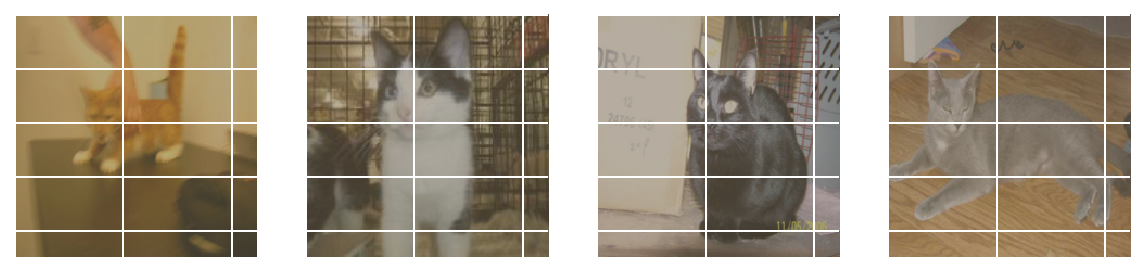

In [28]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
device

device(type='cuda', index=0)

In [0]:
# Optional TODO: Attempt to build a network to classify cats vs dogs from this dataset
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch
from torch import nn
import torch.nn.functional as F


class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 224)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 224)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

In [0]:
# Create the network, define the criterion and optimizer
model = Network(224, 2, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
train(model, trainloader, testloader, criterion, optimizer, epochs=1)

Epoch: 1/1..  Training Loss: 0.084..  Test Loss: 16.274..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.000..  Test Loss: 18.048..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.000..  Test Loss: 18.188..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.000..  Test Loss: 18.251..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.000..  Test Loss: 18.349..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.000..  Test Loss: 18.459..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.000..  Test Loss: 18.674..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.000..  Test Loss: 19.071..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 2.121..  Test Loss: 0.698..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.538..  Test Loss: 3.799..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.018..  Test Loss: 22.691..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.002..  Test Loss: 28.165..  Test Accuracy: 0.500
Epoch: 1/1..  Training Loss: 0.001..  Test